# Prediction of COVID-19 around the world

Student: Angela Amador

TMU Student Number: 500259095

Supervisor: Tamer Abdou, PhD


I aim to demonstrate how Machine Learning (ML) models were able to predict the spread of COVID-19 around the world.

First, I will explore the dataset to get insides and better understand patterns, detect error and outliers, and find relationships between variables. 


## Preparation
Describing the working dataset and any imposed constraints

This dataset is taken from Our World in Data website, officially collected by Our World in Data team: https://covid.ourworldindata.org/data/owid-covid-data.csv.

This dataset will be synced daily. For more info: https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset

In [170]:
# Import libraries
import pandas as pd
from ydata_profiling import ProfileReport
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from sklearn.feature_selection import VarianceThreshold

import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix



### Load file and explore data

The dataset, provided by Our World in Data, provides COVID-19 information collected by Our World in Data available to Kaggle community https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset/download?datasetVersionNumber=418. This dataset is updated daily, for the purpose of this study I am analyzing the data with information up to Oct 7th, 2023.

In [171]:
# Load file
raw_data = pd.read_csv('archive.zip', sep=',')  

#Explore data
raw_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


### Check the data type and metadata of the attributes

In [172]:
raw_data.dtypes

iso_code                                       object
continent                                      object
location                                       object
date                                           object
total_cases                                   float64
new_cases                                     float64
new_cases_smoothed                            float64
total_deaths                                  float64
new_deaths                                    float64
new_deaths_smoothed                           float64
total_cases_per_million                       float64
new_cases_per_million                         float64
new_cases_smoothed_per_million                float64
total_deaths_per_million                      float64
new_deaths_per_million                        float64
new_deaths_smoothed_per_million               float64
reproduction_rate                             float64
icu_patients                                  float64
icu_patients_per_million    

In [173]:
# look at meta information about data, such as null values
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346567 entries, 0 to 346566
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    346567 non-null  object 
 1   continent                                   330089 non-null  object 
 2   location                                    346567 non-null  object 
 3   date                                        346567 non-null  object 
 4   total_cases                                 308672 non-null  float64
 5   new_cases                                   337028 non-null  float64
 6   new_cases_smoothed                          335769 non-null  float64
 7   total_deaths                                287169 non-null  float64
 8   new_deaths                                  337072 non-null  float64
 9   new_deaths_smoothed                         335842 non-null  float64
 

In [174]:
# Let's see meta information about numeric data, we can also see if there any extreme values
raw_data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,3.086720e+05,3.370280e+05,3.357690e+05,2.871690e+05,337072.000000,335842.000000,308672.000000,337028.000000,335769.000000,287169.000000,...,198833.000000,131627.000000,237221.000000,318823.000000,260466.000000,3.465670e+05,1.195300e+04,11953.000000,11953.000000,11953.000000
mean,6.609069e+06,9.695906e+03,9.732069e+03,8.559525e+04,86.392889,86.704207,100634.394008,146.569024,147.113196,867.354640,...,32.909864,50.789455,3.097109,73.714185,0.722460,1.283225e+08,5.113535e+04,9.739424,11.461129,1646.844959
std,4.032547e+07,1.108324e+05,9.495414e+04,4.380493e+05,616.815791,561.926045,150292.226515,1169.506821,602.840371,1096.750172,...,13.574185,31.956355,2.548353,7.395560,0.148979,6.603117e+08,1.442796e+05,12.380781,25.354695,1929.159161
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.700000,1.188000,0.100000,53.280000,0.394000,4.700000e+01,-3.772610e+04,-44.230000,-95.920000,-2752.924800
25%,7.988750e+03,0.000000e+00,2.860000e-01,1.250000e+02,0.000000,0.000000,2573.783500,0.000000,0.056000,59.672000,...,22.600000,20.859000,1.300000,69.590000,0.602000,4.490020e+05,1.066000e+02,1.320000,-1.620000,65.345720
50%,6.904700e+04,2.000000e+00,2.585700e+01,1.313000e+03,0.000000,0.143000,27720.494000,0.169000,6.815000,374.322000,...,33.100000,49.839000,2.500000,75.050000,0.740000,5.882259e+06,5.736601e+03,8.070000,5.770000,1072.472700
75%,7.345502e+05,2.730000e+02,5.107140e+02,1.181800e+04,3.000000,5.286000,131483.602000,36.566000,84.076000,1356.019000,...,41.300000,82.502000,4.200000,79.460000,0.829000,2.830170e+07,3.668959e+04,15.470000,16.520000,2704.933800
max,7.711505e+08,8.401961e+06,6.402036e+06,6.960770e+06,27939.000000,14821.857000,737554.506000,228872.025000,37241.781000,6511.209000,...,78.100000,100.000000,13.800000,86.750000,0.957000,7.975105e+09,1.289776e+06,76.550000,377.630000,10292.916000


### Removing data before COVID vaccine availability

Multiple vaccinates became available on the second semester of 2020. By December most contries have approved vaccinates for their own country. 

To avoid ..xxxxxx... we will remove data before Jan 1st, 2021 to consider data only with vaccinate availability

In [175]:
print("Original dataset:")
print("Total number of observations: ", raw_data.shape[0])
print("Total number of attributes: ", raw_data.shape[1])
print("Size: ", raw_data.size)


post_vaccine_data = raw_data.drop(raw_data[raw_data.date < '2021-01-01'].index)

print("\nAfter removing data before vaccinate was available around the world (Jan 1st, 2021):")
print("Total number of observations: ", post_vaccine_data.shape[0])
print("Total number of attributes: ", post_vaccine_data.shape[1])
print("Size: ", post_vaccine_data.size)


Original dataset:
Total number of observations:  346567
Total number of attributes:  67
Size:  23219989

After removing data before vaccinate was available around the world (Jan 1st, 2021):
Total number of observations:  255173
Total number of attributes:  67
Size:  17096591


# Dimensional Reduction (CMTH642 - Module 9)

Due to the size of the dataset with 255,173 entries and 67 columns, I am going to apply dimensional reduction to provide better features for statistical learning methods

## 1. Removing data columns with too many NaN values

We can calculate the ratio of missing values using a simple formula. The formula is- the number of missing values in each column divided by the total number of observation. Generally, we can drop variables having a missing value ratio of more than 60% or 70%. For my purpose I am going to use a threashold of 60% missing values and remove those attributes.

In [176]:
# Defining threashold of 60% missing values 
threashold_NaN = 0.60

#Explore data
def describe_nan(df):
    return pd.DataFrame([(i, df[df[i].isna()].shape[0],df[df[i].isna()].shape[0]/df.shape[0]) for i in df.columns], columns=['column', 'nan_counts', 'nan_rate'])

pd.options.display.max_rows = None

#icu=raw_data.icu_patients.value_counts(dropna=False)
#display ("NaN entries for the icu_patients column:", icu[icu.index.isnull()])

print("Attributes with more than 60 percentage of missing values:")

describe_nan(post_vaccine_data).sort_values(by="nan_rate", ascending=False).query("nan_rate >= %s"%threashold_NaN)

#((raw_data.isnull() | raw_data.isna()).sum() * 100 / raw_data.index.size).round(2)

Attributes with more than 60 percentage of missing values:


,column,nan_counts,nan_rate
66,excess_mortality_cumulative_per_million,246760,0.967030
65,excess_mortality,246760,0.967030
64,excess_mortality_cumulative,246760,0.967030
63,excess_mortality_cumulative_absolute,246760,0.967030
21,weekly_icu_admissions,246705,0.966815
22,weekly_icu_admissions_per_million,246705,0.966815
23,weekly_hosp_admissions,237173,0.929460
24,weekly_hosp_admissions_per_million,237173,0.929460
17,icu_patients,226284,0.886787
18,icu_patients_per_million,226284,0.886787


In [177]:

my_columns = describe_nan(post_vaccine_data).sort_values(by="nan_rate", ascending=False).query("nan_rate < %s"%threashold_NaN)[["column"]]
my_columns = my_columns['column'].to_list() 

#dr1 -> Dimensionality Reduction - 1. Removing data columns with too many missing values
dr1_data = post_vaccine_data[my_columns]

print("After removing columns with more than 60 percentage of missing values:\n")
print("Total number of observations: ", dr1_data.shape[0])
print("Total number of attributes: ", dr1_data.shape[1])
print("Size: ", dr1_data.size)
print("\n")
dr1_data.info()

After removing columns with more than 60 percentage of missing values:

Total number of observations:  255173
Total number of attributes:  36
Size:  9186228


<class 'pandas.core.frame.DataFrame'>
Index: 255173 entries, 364 to 346566
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   extreme_poverty                             126910 non-null  float64
 1   stringency_index                            132092 non-null  float64
 2   reproduction_rate                           137489 non-null  float64
 3   male_smokers                                146049 non-null  float64
 4   female_smokers                              148063 non-null  float64
 5   hospital_beds_per_thousand                  174245 non-null  float64
 6   new_people_vaccinated_smoothed              179462 non-null  float64
 7   new_people_vaccinated_smoothed_per_hundred  179462 non-null  f

In [178]:
print("Percentage of NaN values per attribute for the remaining columns:\n")
describe_nan(dr1_data).sort_values(by="nan_rate", ascending=False)

# del(dr1_data)

Percentage of NaN values per attribute for the remaining columns:



,column,nan_counts,nan_rate
0,extreme_poverty,128263,0.502651
1,stringency_index,123081,0.482343
2,reproduction_rate,117684,0.461193
3,male_smokers,109124,0.427647
4,female_smokers,107110,0.419754
5,hospital_beds_per_thousand,80928,0.317150
6,new_people_vaccinated_smoothed,75711,0.296705
7,new_people_vaccinated_smoothed_per_hundred,75711,0.296705
9,new_vaccinations_smoothed_per_million,75551,0.296078
8,new_vaccinations_smoothed,75551,0.296078


## 2. Low Variance Filter

Another way of measuring how much information a data column has, is to measure its variance. In the limit case where the column cells assume a constant value, the variance would be 0 and the column would be of no help in the discrimination of different groups of data.

The Low Variance Filter node calculates each column variance and removes those columns with a variance value below a given threshold. Notice that the variance can only be calculated for numerical columns, i.e. this dimensionality reduction method applies only to numerical columns. Note, too, that the variance value depends on the column numerical range. Therefore data column ranges need to be normalized to make variance values independent from the column domain range.

First a Normalizer node normalizes all column ranges to [0, 1]; next, a Low Variance Filter node calculates the columns variance and filters out the columns with a variance lower than a set threshold.

In [179]:
# Initialization is just like any other Scikit-learn estimator. The default value for the threshold is always 0. 
# Also, the estimator only works with numeric data obviously and it will raise an error if there are categorical features present in the dataframe. 
# That’s why, for now, I will subset the numeric features into another dataframe:

vt = VarianceThreshold()

#dr2 -> Dimensionality Reduction - 2. Removing low variance filter
dr2_data_num = dr1_data.select_dtypes(include="number")
#dr2_data_num.shape
#dr2_data_num.info()


In [180]:
# Before, I need to take care of missing values encoded as NaN natively by replacing with the mean on reduced dataset "dr2_data_reduced"

print ("Before replacing NaN values with the mean:\n")
print("Total number of observations: ", dr2_data_num.shape[0])
print("Total number of attributes: ", dr2_data_num.shape[1])
print("Size: ", dr2_data_num.size)
print("\n")
dr2_data_num.info()

for c in dr2_data_num.columns:
    dr2_data_num[c] = dr2_data_num[c].fillna(dr2_data_num[c].mean())

print ("\nAfter replacing NaN values with the mean:\n")
print("Total number of observations: ", dr2_data_num.shape[0])
print("Total number of attributes: ", dr2_data_num.shape[1])
print("Size: ", dr2_data_num.size)
print("\n")
dr2_data_num.info()

Before replacing NaN values with the mean:

Total number of observations:  255173
Total number of attributes:  32
Size:  8165536


<class 'pandas.core.frame.DataFrame'>
Index: 255173 entries, 364 to 346566
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   extreme_poverty                             126910 non-null  float64
 1   stringency_index                            132092 non-null  float64
 2   reproduction_rate                           137489 non-null  float64
 3   male_smokers                                146049 non-null  float64
 4   female_smokers                              148063 non-null  float64
 5   hospital_beds_per_thousand                  174245 non-null  float64
 6   new_people_vaccinated_smoothed              179462 non-null  float64
 7   new_people_vaccinated_smoothed_per_hundred  179462 non-null  float64
 8   new_vaccinations

In [181]:
# First, we fit the estimator to data and call its get_support() method. It returns a boolean mask with True values for columns which are not dropped. 
# We can then use this mask to subset our DataFrame like so

_ = vt.fit(dr2_data_num)
mask = vt.get_support()

dr2_data_num = dr2_data_num.loc[:, mask]

# dr2_data_num.shape

# dr2_data_num.info()


In [182]:
# We still have the same number of features. Now, let’s drop features with variances close to 0
vt = VarianceThreshold(threshold=1)

# Fit
_ = vt.fit(dr2_data_num)

# # Get the boolean mask
mask = vt.get_support()

dr2_data_reduced = dr2_data_num.loc[:, mask]

print ("\nAfter dropping features with variances close to 0:\n")
print("Total number of observations: ", dr2_data_reduced.shape[0])
print("Total number of attributes: ", dr2_data_reduced.shape[1])
print("Size: ", dr2_data_reduced.size)
print("\n")
dr2_data_reduced.info()

# With a threshold of 1, 3 attributes were removedthreshold
# From: (255173, 32)
# To: (255173, 29)


After dropping features with variances close to 0:

Total number of observations:  255173
Total number of attributes:  29
Size:  7400017


<class 'pandas.core.frame.DataFrame'>
Index: 255173 entries, 364 to 346566
Data columns (total 29 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   extreme_poverty                        255173 non-null  float64
 1   stringency_index                       255173 non-null  float64
 2   male_smokers                           255173 non-null  float64
 3   female_smokers                         255173 non-null  float64
 4   hospital_beds_per_thousand             255173 non-null  float64
 5   new_people_vaccinated_smoothed         255173 non-null  float64
 6   new_vaccinations_smoothed              255173 non-null  float64
 7   new_vaccinations_smoothed_per_million  255173 non-null  float64
 8   aged_65_older                          255173 non-null  f

In [183]:
# The attributes that were dropped are:
# - reproduction_rate
# - new_people_vaccinated_smoothed_per_hundred
# - human_development_index

In [184]:
# Method of normalizing all features by dividing them by their mean

normalized_df = dr2_data_num / dr2_data_num.mean()
normalized_df.head()

print("Variance of the normalized dataset:\n")
normalized_df.var()

,extreme_poverty,stringency_index,reproduction_rate,male_smokers,female_smokers,hospital_beds_per_thousand,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,...,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,new_cases,new_cases_smoothed,new_deaths_smoothed_per_million,new_deaths_smoothed,new_deaths_per_million,new_deaths,population
364,1.0,0.309718,0.991848,1.0,1.0,0.161439,1.0,1.0,1.0,1.0,...,0.009977,0.024114,0.017253,0.015494,0.011077,0.233626,0.110464,0.299663,0.141538,0.321068
365,1.0,0.309718,0.980315,1.0,1.0,0.161439,1.0,1.0,1.0,1.0,...,0.009990,0.009621,0.015446,0.006181,0.009919,0.223424,0.105438,0.249377,0.117949,0.321068
366,1.0,0.309718,0.980315,1.0,1.0,0.161439,1.0,1.0,1.0,1.0,...,0.010014,0.016211,0.016182,0.010414,0.010389,0.223424,0.105438,0.249377,0.117949,0.321068
367,1.0,0.309718,0.980315,1.0,1.0,0.161439,1.0,1.0,1.0,1.0,...,0.010052,0.026358,0.016950,0.016933,0.010884,0.212202,0.100412,0.224747,0.106154,0.321068
368,1.0,0.309718,0.968782,1.0,1.0,0.161439,1.0,1.0,1.0,1.0,...,0.010071,0.013442,0.016236,0.008636,0.010426,0.194859,0.092047,0.174461,0.082564,0.321068


Variance of the normalized dataset:



extreme_poverty                                 1.047002
stringency_index                                0.163080
reproduction_rate                               0.114146
male_smokers                                    0.097370
female_smokers                                  0.579030
hospital_beds_per_thousand                      0.462300
new_people_vaccinated_smoothed                 36.227829
new_people_vaccinated_smoothed_per_hundred      3.587963
new_vaccinations_smoothed                      29.976837
new_vaccinations_smoothed_per_million           1.823817
human_development_index                         0.031885
aged_65_older                                   0.372831
gdp_per_capita                                  0.860112
cardiovasc_death_rate                           0.161974
aged_70_older                                   0.440998
median_age                                      0.069842
diabetes_prevalence                             0.270828
population_density             

In [185]:
# Now, we can use the estimator with a lower threshold like 0.005
vt = VarianceThreshold(threshold=0.005)

# Fit
_ = vt.fit(normalized_df)

# # Get the boolean mask
mask = vt.get_support()

dr2_data_final = dr2_data_num.loc[:, mask]

dr2_data_final.shape

# With a threshold of 0.05, zero attributes were removed threshold
# From: (255173, 32)
# To: (255173, 32)

(255173, 32)

In [186]:
# dr2_data_reduced.columns.get_loc('total_cases')
# dr2_data_reduced.shape[1]

In [187]:
# With method of normalizing no attributes were removed; while with variances close to 0, 3 features were removed.
# - reproduction_rate
# - new_people_vaccinated_smoothed_per_hundred
# - human_development_index

# I will check if it is rigth to removed these 3 attributes. I will test this by training two RandomForestRegressor to predict a total_cases: the first one on the reduced dataset (dr2_data_reduced), feature selected dataset
# and the second one on the full, numeric-feature only dataset (dr2_data_num).

#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split

# Find out the index of total_cases column
c = dr2_data_reduced.columns.get_loc('total_cases')

# Find out number of columns
d = dr2_data_reduced.shape[1]

# Build feature, target arrays
X, y = dr2_data_reduced.iloc[:, [i for i in range(d) if i != c]], dr2_data_reduced.iloc[:, [c]]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1121218)

# Init, fit, score
forest = RandomForestRegressor(random_state=1121218)

_ = forest.fit(X_train, y_train)

# Training Score
print(f"Training Score: {forest.score(X_train, y_train)}")
#Training Score: 0.988528867222243

print(f"Test Score: {forest.score(X_test, y_test)}")
# Test Score: 0.9511616691995844

print("Both training and test score suggest a really high performance without overfitting.")

Training Score: 0.99999558195038
Test Score: 0.999939749365203
Both training and test score suggest a really high performance without overfitting.


In [188]:
# dr2_data_num.columns.get_loc('total_cases')
# dr2_data_num.shape[1]

In [189]:
# Now, let’s train the same model on the full numeric-only dataset

# Find out the index of total_cases column
c = dr2_data_num.columns.get_loc('total_cases')

# Find out number of columns
d = dr2_data_num.shape[1]


# Build feature, target arrays
X, y = dr2_data_num.iloc[:, [i for i in range(d) if i != c]], dr2_data_num.iloc[:, [c]]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1121218)

# Init, fit, score
forest = RandomForestRegressor(random_state=1121218)

_ = forest.fit(X_train, y_train)

# Training Score
print(f"Training Score: {forest.score(X_train, y_train)}")
#Training Score: 0.988528867222243

print(f"Test Score: {forest.score(X_test, y_test)}")

print("I can confirm that there isn't any impact on the prediction by removing these 3 features")

#Freeing memory
del(X)
del(y)
del(X_train)
del(X_test)
del(y_train)
del(y_test)
# del(dr2_data_num)
# del(dr2_data_reduced)
# del(dr2_data_final)
del(normalized_df)

Training Score: 0.9999913671844262
Test Score: 0.9999016507751846
I can confirm that there isn't any impact on the prediction by removing these 3 features


In [190]:
# Droping the columns identified with variance close to 0
# - reproduction_rate
# - new_people_vaccinated_smoothed_per_hundred
# - human_development_index

dr2_data = dr1_data.drop(['reproduction_rate', 'new_people_vaccinated_smoothed_per_hundred', 'human_development_index'], axis=1)
print("After removing columns identified with variance close to 0:\n")
print("Total number of observations: ", dr2_data.shape[0])
print("Total number of attributes: ", dr2_data.shape[1])
print("Size: ", dr2_data.size)
print("\n")
dr2_data.info()

After removing columns identified with variance close to 0:

Total number of observations:  255173
Total number of attributes:  33
Size:  8420709


<class 'pandas.core.frame.DataFrame'>
Index: 255173 entries, 364 to 346566
Data columns (total 33 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   extreme_poverty                        126910 non-null  float64
 1   stringency_index                       132092 non-null  float64
 2   male_smokers                           146049 non-null  float64
 3   female_smokers                         148063 non-null  float64
 4   hospital_beds_per_thousand             174245 non-null  float64
 5   new_people_vaccinated_smoothed         179462 non-null  float64
 6   new_vaccinations_smoothed              179622 non-null  float64
 7   new_vaccinations_smoothed_per_million  179622 non-null  float64
 8   aged_65_older                          194141 non

## 3. High correlation with other data columns


* https://www.kaggle.com/code/bbloggsbott/feature-selection-correlation-and-p-value

### Selecting columns based on correlation

,extreme_poverty,stringency_index,male_smokers,female_smokers,hospital_beds_per_thousand,new_people_vaccinated_smoothed,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,aged_65_older,gdp_per_capita,...,new_cases,new_cases_smoothed,new_deaths_smoothed_per_million,new_deaths_smoothed,new_deaths_per_million,new_deaths,population,date,location,iso_code
extreme_poverty,1.000000,-0.104870,-0.192305,-0.411078,-0.443514,-0.021389,-0.031198,-0.196236,-0.573979,-0.502392,...,-0.027644,-0.030553,-0.210197,-0.039553,-0.111540,-0.037453,-0.025284,-1.603214e-04,0.041243,0.074164
stringency_index,-0.104870,1.000000,0.063403,-0.092286,-0.020628,0.161439,0.148472,0.331047,-0.006704,0.014314,...,0.024830,0.027412,0.274914,0.174567,0.152339,0.150895,0.144791,-6.709993e-01,0.014137,0.008284
male_smokers,-0.192305,0.063403,1.000000,0.226511,0.347231,0.008857,0.021132,0.016076,0.084377,-0.102326,...,0.008733,0.009748,0.078138,0.004446,0.041541,0.004229,0.014974,2.357157e-05,0.034503,0.012612
female_smokers,-0.411078,-0.092286,0.226511,1.000000,0.473754,-0.046677,-0.051317,0.089861,0.733060,0.309315,...,-0.004214,-0.004692,0.236108,-0.007409,0.127345,-0.007083,-0.064247,1.901350e-04,-0.047569,-0.092346
hospital_beds_per_thousand,-0.443514,-0.020628,0.347231,0.473754,1.000000,-0.016451,-0.005088,0.111612,0.602605,0.291044,...,0.017094,0.019100,0.145092,0.000627,0.078420,0.000575,-0.023034,8.876861e-05,0.026951,0.001633
new_people_vaccinated_smoothed,-0.021389,0.161439,0.008857,-0.046677,-0.016451,1.000000,0.926793,0.100686,-0.000340,-0.018018,...,0.244859,0.283370,0.003234,0.669298,0.001643,0.614991,0.603048,-1.000845e-01,0.031833,0.058618
new_vaccinations_smoothed,-0.031198,0.148472,0.021132,-0.051317,-0.005088,0.926793,1.000000,0.110139,0.007419,-0.016192,...,0.333956,0.386131,-0.003581,0.691898,-0.001994,0.635201,0.673488,-8.437316e-02,0.035413,0.059851
new_vaccinations_smoothed_per_million,-0.196236,0.331047,0.016076,0.089861,0.111612,0.100686,0.110139,1.000000,0.147935,0.193790,...,0.016114,0.017367,0.159707,0.055612,0.086719,0.050778,-0.015322,-3.723620e-01,0.018064,-0.012434
aged_65_older,-0.573979,-0.006704,0.084377,0.733060,0.602605,-0.000340,0.007419,0.147935,1.000000,0.499053,...,0.033324,0.037318,0.267082,0.031101,0.147166,0.029290,-0.002307,-2.645612e-04,-0.037126,-0.110928
gdp_per_capita,-0.502392,0.014314,-0.102326,0.309315,0.291044,-0.018018,-0.016192,0.193790,0.499053,1.000000,...,0.015813,0.017735,0.103290,0.011131,0.055520,0.010427,-0.025976,-4.474758e-03,0.026129,-0.080465


<Axes: >

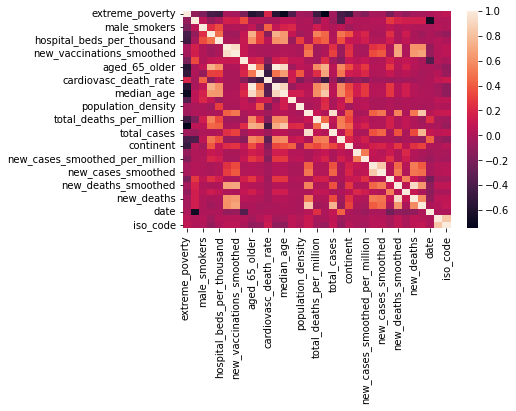

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# Dataset copy to be use in the correlation, remove the column total_cases because it is the column we are trying to predict
#data = raw_data.drop(['total_cases'], axis=1)
dr3_data_corr = dr2_data.copy()

# The numpy.random.seed() makes the random numbers predictable and is used for reproducibility
np.random.seed(123)

# Find out the index for categorical variables
continent = dr3_data_corr.columns.get_loc('continent')
location = dr3_data_corr.columns.get_loc('location')
date = dr3_data_corr.columns.get_loc('date')
iso_code = dr3_data_corr.columns.get_loc('iso_code')

# Encode the Categorical Variable
# The dataset has 3 categorical attributes: date, continent and location
label_encoder = LabelEncoder()
dr3_data_corr.iloc[:,continent] = label_encoder.fit_transform(dr3_data_corr.iloc[:,continent]).astype('float64')
dr3_data_corr.iloc[:,location] = label_encoder.fit_transform(dr3_data_corr.iloc[:,location]).astype('float64')
dr3_data_corr.iloc[:,date] = label_encoder.fit_transform(dr3_data_corr.iloc[:,date]).astype('float64')
dr3_data_corr.iloc[:,iso_code] = label_encoder.fit_transform(dr3_data_corr.iloc[:,iso_code]).astype('float64')

corr = dr3_data_corr.corr()
corr

sns.heatmap(corr)

In [225]:
# Next, compare the correlation between features and remove one of two features that have a correlation higher than 0.9

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = dr3_data_corr.columns[columns]
# selected_columns
# selected_columns.shape

## Add total_cases column which is the column to be predicted
total_cases = pd.Index(['total_cases'])
selected_columns = selected_columns.append(total_cases)
selected_columns
selected_columns.shape


Index(['extreme_poverty', 'stringency_index', 'male_smokers', 'female_smokers',
       'hospital_beds_per_thousand', 'new_people_vaccinated_smoothed',
       'new_vaccinations_smoothed_per_million', 'aged_65_older',
       'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'population_density', 'total_deaths', 'total_deaths_per_million',
       'life_expectancy', 'total_cases_per_million', 'continent',
       'new_cases_per_million', 'new_cases_smoothed_per_million', 'new_cases',
       'new_cases_smoothed', 'new_deaths_smoothed_per_million',
       'new_deaths_smoothed', 'new_deaths_per_million', 'population', 'date',
       'location', 'iso_code', 'total_cases'],
      dtype='object')

(29,)

In [226]:
dr3_data_corr = dr3_data_corr[selected_columns]

### Selecting columns based on p-value

Selecting the columns based on how they affect the p-value. 

Column total_cases because was removed, this is the column to be predicted

In [227]:
# Removing the total_cases column
selected_columns = selected_columns[0:-1].values

In [228]:
# Take care of missing values encoded as NaN natively by replacing with the mean 

print ("Before replacing NaN values with the mean:\n")
print("Total number of observations: ", dr3_data_corr.shape[0])
print("Total number of attributes: ", dr3_data_corr.shape[1])
print("Size: ", dr3_data_corr.size)
print("\n")
dr3_data_corr.info()

for c in dr3_data_corr.columns:
    dr3_data_corr[c] = dr3_data_corr[c].fillna(dr3_data_corr[c].mean())

print ("After replacing NaN values with the mean:\n")
print("Total number of observations: ", dr3_data_corr.shape[0])
print("Total number of attributes: ", dr3_data_corr.shape[1])
print("Size: ", dr3_data_corr.size)
print("\n")
dr3_data_corr.info()

Before replacing NaN values with the mean:

Total number of observations:  255173
Total number of attributes:  29
Size:  7400017


<class 'pandas.core.frame.DataFrame'>
Index: 255173 entries, 364 to 346566
Data columns (total 29 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   extreme_poverty                        126910 non-null  float64
 1   stringency_index                       132092 non-null  float64
 2   male_smokers                           146049 non-null  float64
 3   female_smokers                         148063 non-null  float64
 4   hospital_beds_per_thousand             174245 non-null  float64
 5   new_people_vaccinated_smoothed         179462 non-null  float64
 6   new_vaccinations_smoothed_per_million  179622 non-null  float64
 7   aged_65_older                          194141 non-null  float64
 8   gdp_per_capita                         197162 non-null  float64
 9

In [229]:
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    #x=np.array(x, dtype=float)
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    
    return x, columns, regressor_OLS.summary()

In [212]:
# dr3_data_corr.head()
# dr3_data_corr.iloc[:,:-1].values 
# dr3_data_corr.iloc[:,-1].values
# selected_columns

In [230]:
SL = 0.05
data_modeled, selected_columns, summary = backwardElimination(
    dr3_data_corr.iloc[:,:-1].values ,
    dr3_data_corr.iloc[:,-1].values,
    SL,
    selected_columns)


In [232]:
# data_modeled
# selected_columns
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                          1.334e+05
Date:                Thu, 19 Oct 2023   Prob (F-statistic):                        0.00
Time:                        23:52:49   Log-Likelihood:                     -4.5212e+06
No. Observations:              255173   AIC:                                  9.042e+06
Df Residuals:                  255148   BIC:                                  9.043e+06
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.728e+04   1666.988     16.364      0.000     2.4e+04    3.05e+04
x2          2.558e+04   2747.138      9.313      0.000    2.02e+04     3.1e+04
x3         -2.893e+04   3994.353     -7.242      0.000   -3.68e+04   -2.11e+04
x4          1.607e+05   1.47e+04     10.940      0.000    1.32e+05    1.89e+05
x5            -7.9998      0.052   -155.283      0.000      -8.101      -7.899
x6           -61.7063      9.590     -6.435      0.000     -80.502     -42.910
x7          2.219e+05   8216.006     27.007      0.000    2.06e+05    2.38e+05
x8            -6.1421      1.867     -3.289      0.001      -9.802      -2.482
x9         -1723.8935    275.028     -6.268      0.000   -2262.941   -1184.846
x10         1.515e+04   6175.117      2.453      0.014    3042.232    2.72e+04
x11          -90.2790     14.398     -6.270      0.000    -118.499     -62.059
x12           97.1899      0.104    933.054      0.000      96.986      97.394
x13        -2178.7224     29.992    -72.644      0.000   -2237.506   -2119.939
x14        -2.339e+04   2164.860    -10.806      0.000   -2.76e+04   -1.92e+04
x15           17.0452      0.217     78.449      0.000      16.619      17.471
x16        -7.428e+05   1.84e+04    -40.443      0.000   -7.79e+05   -7.07e+05
x17         -206.5625     36.700     -5.628      0.000    -278.493    -134.632
x18           -5.9921      0.344    -17.417      0.000      -6.666      -5.318
x19           14.3439      0.434     33.027      0.000      13.493      15.195
x20         1.955e+05   9080.185     21.534      0.000    1.78e+05    2.13e+05
x21        -1.246e+04     68.452   -182.079      0.000   -1.26e+04   -1.23e+04
x22            0.0053   7.99e-05     65.841      0.000       0.005       0.005
x23         1799.9889     98.998     18.182      0.000    1605.955    1994.022
x24        -5.034e+04    595.345    -84.564      0.000   -5.15e+04   -4.92e+04
x25         3.839e+04    589.674     65.106      0.000    3.72e+04    3.95e+04
==============================================================================
Omnibus:                   179125.439   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33671006.093
Skew:                           2.411   Prob(JB):                         0.00
Kurtosis:                      59.068   Cond. No.                     5.26e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.26e+08. This might indicate that there are
strong multicollinearit

In [240]:
result = pd.DataFrame()
result['total_cases'] = dr3_data_corr.iloc[:,-1]

dr3_data = pd.DataFrame(data = data_modeled, columns = selected_columns)

dr3_data['total_cases'] = result['total_cases'] 

dr3_data.head()

,stringency_index,male_smokers,female_smokers,hospital_beds_per_thousand,new_people_vaccinated_smoothed,new_vaccinations_smoothed_per_million,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,...,new_cases_smoothed_per_million,new_cases,new_cases_smoothed,new_deaths_smoothed_per_million,new_deaths_smoothed,population,date,location,iso_code,total_cases
0,12.04,32.910081,10.791209,0.5,113378.115412,1992.902378,2.581,1803.987,597.029,9.59,...,3.189,183.0,131.143,0.229,9.429,41128772.0,0.0,0.0,1.0,NaN
1,12.04,32.910081,10.791209,0.5,113378.115412,1992.902378,2.581,1803.987,597.029,9.59,...,2.855,73.0,117.429,0.219,9.000,41128772.0,1.0,0.0,1.0,NaN
2,12.04,32.910081,10.791209,0.5,113378.115412,1992.902378,2.581,1803.987,597.029,9.59,...,2.991,123.0,123.000,0.219,9.000,41128772.0,2.0,0.0,1.0,NaN
3,12.04,32.910081,10.791209,0.5,113378.115412,1992.902378,2.581,1803.987,597.029,9.59,...,3.133,200.0,128.857,0.208,8.571,41128772.0,3.0,0.0,1.0,NaN
4,12.04,32.910081,10.791209,0.5,113378.115412,1992.902378,2.581,1803.987,597.029,9.59,...,3.001,102.0,123.429,0.191,7.857,41128772.0,4.0,0.0,1.0,NaN


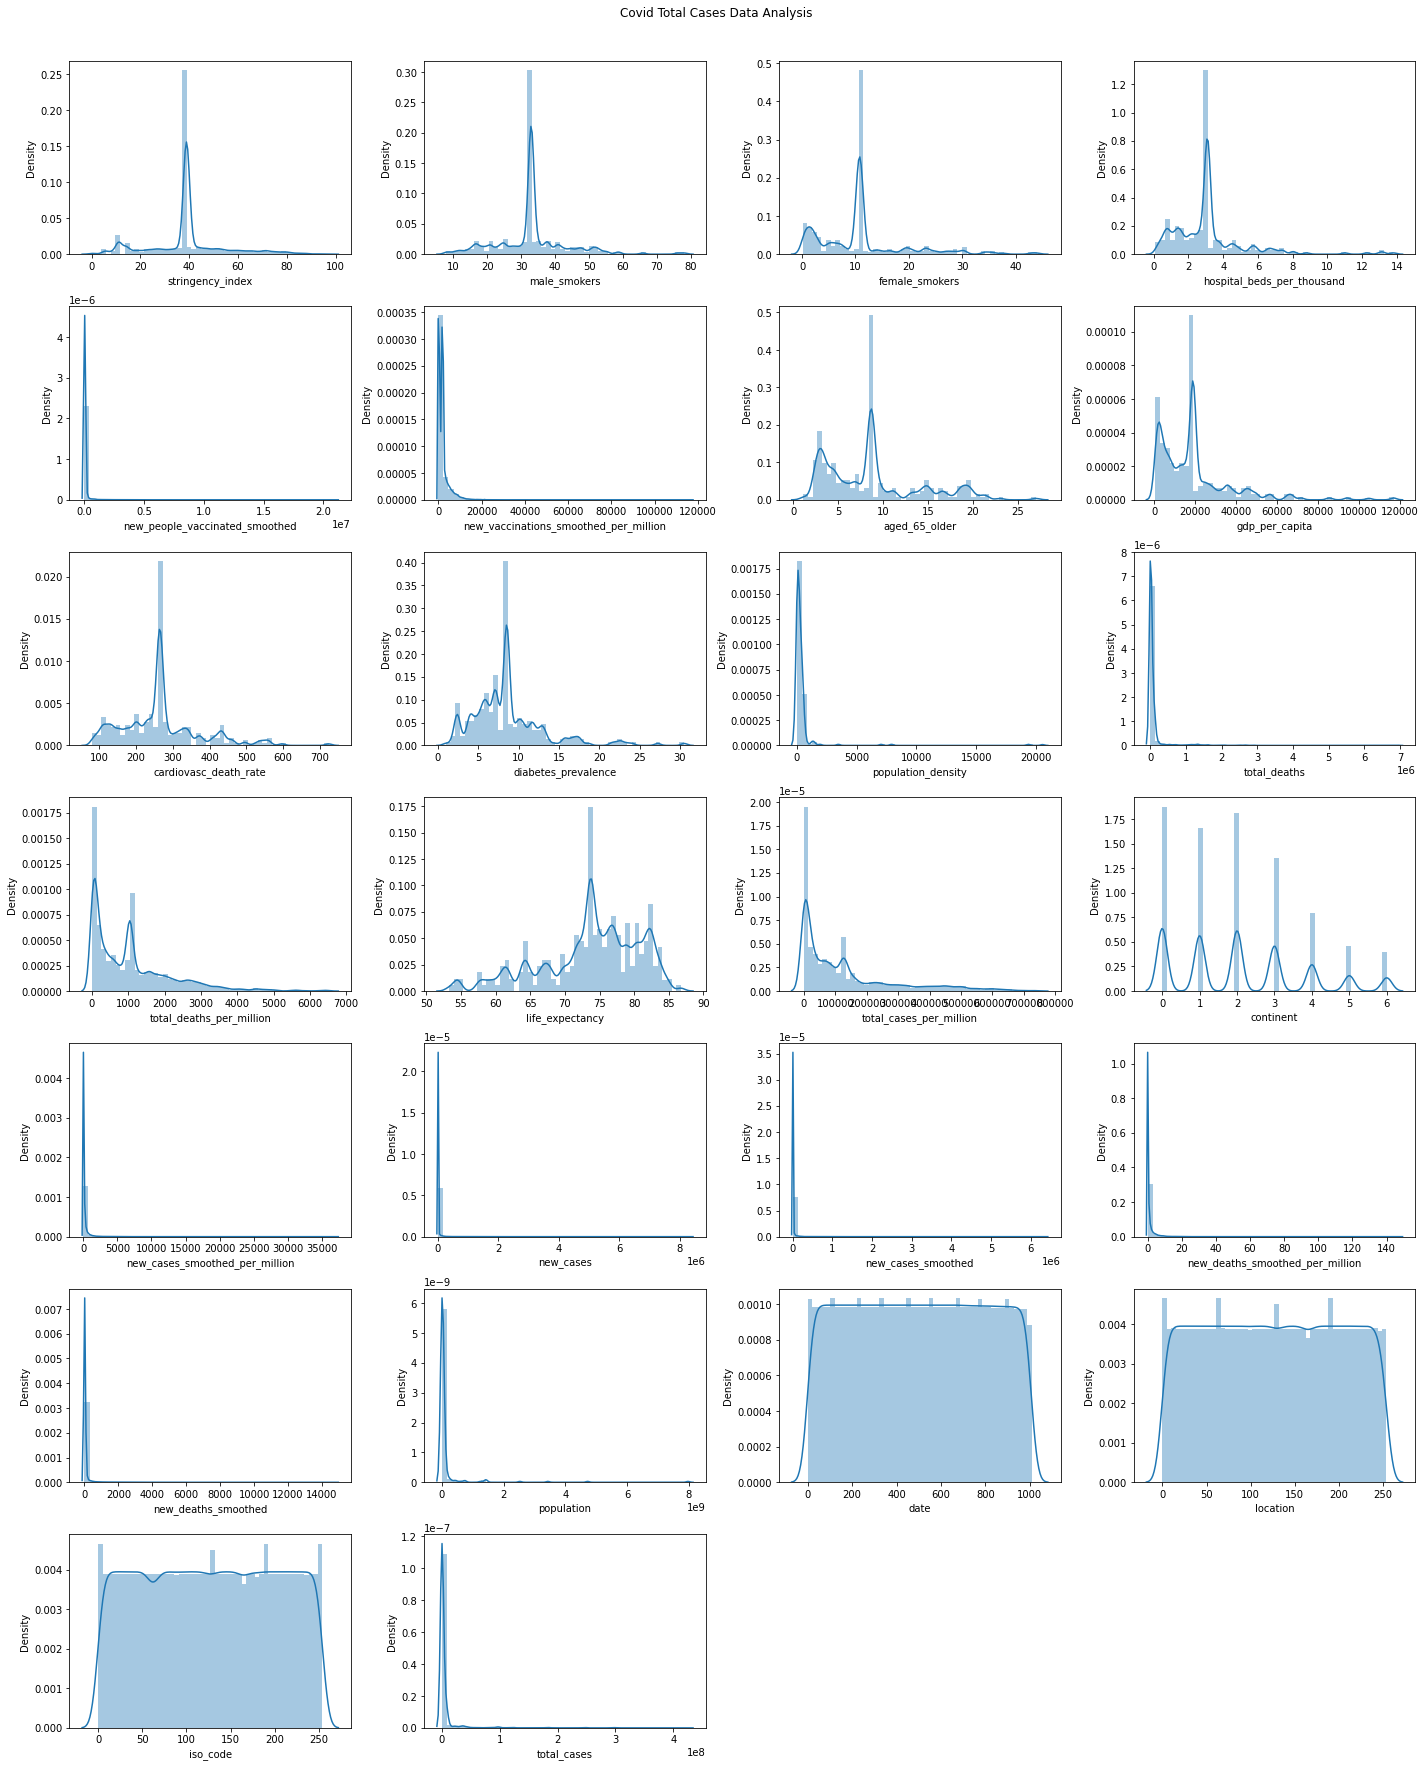

In [250]:

fig = plt.figure(figsize = (20, 25))
j = 0
for i in dr3_data.columns:
    plt.subplot(7, 4, j+1)
    j += 1
    sns.distplot(dr3_data[i])
    #plt.legend(loc='best',fontsize=10)
fig.suptitle('Covid Total Cases Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)


plt.show();

* https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f

# Generate Profiling Report

In [ ]:
# Genetate profiling report
#profile = ProfileReport(raw_data, title="Profiling Report")
#profile = ProfileReport(raw_data, title="Profiling Report", html={'style':{'fullwith':True}})
#profile